<a href="https://colab.research.google.com/github/kprabhakarans/ExKMC_OccupancyEstimation/blob/main/ExKMC_OE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ExKMC

     |████████████████████████████████| 139 kB 31.4 MB/s 
  Created wheel for ExKMC: filename=ExKMC-0.0.3-cp37-cp37m-linux_x86_64.whl size=277390 sha256=13d9b2706d35945e03420576b7ef97b46f62949b9f47ede7d2ba1b90063876af
  Stored in directory: /root/.cache/pip/wheels/5d/65/9c/d88f7f6d8358ba43f0b252fb5d244cf999b5487893d864b8d4
Successfully built ExKMC


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def calc_cost(tree, k, x_data):
    clusters = tree.predict(x_data)
    cost = 0
    for c in range(k):
        cluster_data = x_data[clusters == c]
        if cluster_data.shape[0] > 0:
            center = cluster_data.mean(axis=0)
            for x in cluster_data:
                cost += np.linalg.norm(x - center) ** 2
    return cost

def plot_kmeans(kmeans, x_data):
    cmap = plt.cm.get_cmap('PuBuGn')

    k = kmeans.n_clusters
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]

    ########### K-MEANS Clustering ###########
    plt.figure(figsize=(4, 4))
    Z = kmeans.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap,
               aspect='auto', origin='lower', alpha=0.4)

    y_kmeans = kmeans.predict(x_data)
    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_kmeans, s=20, edgecolors='black', cmap=cmap)
    for c in range(k):
        center = x_data[y_kmeans == c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10,
                    edgecolors='black')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Power consumption")
    plt.ylabel("Door opening")
    plt.title("Near Optimal Baseline", fontsize=14)
    plt.show()
    
    
def plot_tree_boundary(cluster_tree, k, x_data, kmeans, plot_mistakes=False):
    cmap = plt.cm.get_cmap('PuBuGn')
    
    ########### IMM leaves ###########
    plt.figure(figsize=(4, 4))
    
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]
    
    y_cluster_tree = cluster_tree.predict(x_data)

    Z = cluster_tree.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', origin='lower', alpha=0.4)


    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_cluster_tree, edgecolors='black', s=20, cmap=cmap)
    for c in range(k):
        center = x_data[y_cluster_tree==c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10, edgecolors='black')
        
    if plot_mistakes:
        y = kmeans.predict(x_data)
        mistakes = x_data[y_cluster_tree != y]
        plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)

    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Power consumption")
    plt.ylabel("Door Opening")
    plt.title("Approximation Ratio: %.2f" % (cluster_tree.score(x_data) / -kmeans.score(x_data)), fontsize=14)
    plt.show()
    

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=np.array(['Cluster %d' % i for i in range(len(classes))]), 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Cluster label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_df(df, dataset, step=1, ylim=None):
    k = int(df.iloc[0].leaves)
    cols = ["CART", "KDTree", "ExKMC", "ExKMC (base: IMM)"]

    flatui = ["#3498db", "#e74c3c", "#2ecc71", "#34495e"]
    palette = sns.color_palette(flatui)

    plt.figure(figsize=(4,3))
    ax = sns.lineplot(data=df[::step][cols], linewidth=4, palette=palette, markers=True,
                      dashes=False)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 1.01, 1/3) * (df.shape[0] - 1), ['$k$\n$(=%s)$' % k, 
                                                             r'$2 \cdot k$', 
                                                             r'$3 \cdot k$', 
                                                             '$4 \cdot k$\n$(=%s)$' % (4*k)], 
               fontsize=14)
    
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)

    plt.title(dataset, fontsize=22)
    plt.xlabel("# Leaves", fontsize=18)
    ax.xaxis.set_label_coords(0.5, -0.15)
    plt.ylabel("Cost Ratio", fontsize=18)
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from ExKMC.Tree import Tree
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.model_selection import train_test_split

Saving case2.csv to case2.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['case2.csv']))
X = df.iloc[:,[0,1,2,3,4]].values
Y = df.iloc[:,[5]].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=2)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train)
tree_1k = Tree(3,random_state=42,max_leaves=5)
tree_1k.fit(X_train, kmeans)
prediction = tree_1k.fit_predict(X_test,kmeans=kmeans)

y_pred = prediction

print(classification_report(y_test,y_pred,digits=6))
print(f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0   0.971963  0.990476  0.981132       105
           1   0.615385  0.347826  0.444444        23
           2   0.416667  0.625000  0.500000        16

    accuracy                       0.847222       144
   macro avg   0.668005  0.654434  0.641859       144
weighted avg   0.853310  0.847222  0.841952       144

0.8419520149079899


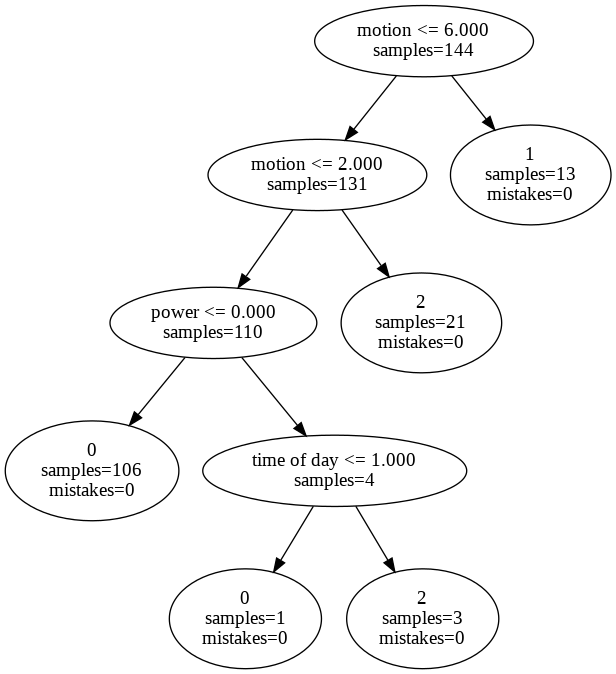

In [ ]:
feature_names=list(['motion','power','door opening','time of day','day type'])
from IPython.display import Image
# Tree plot saved to filename
tree_1k.plot('filename1',feature_names=feature_names)
Image(filename='filename1.gv.png')

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=5, random_state=41)
clf = clf.fit(X_train, y_train)
DT_pred = clf.predict(X_test)
print(classification_report(y_test,DT_pred,digits=4))
print(f1_score(y_test, DT_pred, average='weighted'))

              precision    recall  f1-score   support

           0     0.9633    1.0000    0.9813       105
           1     0.7727    0.7391    0.7556        23
           2     0.7692    0.6250    0.6897        16

    accuracy                         0.9167       144
   macro avg     0.8351    0.7880    0.8088       144
weighted avg     0.9113    0.9167    0.9128       144

0.9128447480136705


In [ ]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
graph.render("decision_tree_graphivz_3tree")

'decision_tree_graphivz_3tree.png'

In [ ]:
text_representation = tree.export_text(clf,feature_names=feature_names)
print(text_representation)

|--- power <= 0.50
|   |--- door opening <= 0.00
|   |   |--- class: 0
|   |--- door opening >  0.00
|   |   |--- time of day <= 1.50
|   |   |   |--- class: 0
|   |   |--- time of day >  1.50
|   |   |   |--- class: 1
|--- power >  0.50
|   |--- power <= 1.50
|   |   |--- class: 1
|   |--- power >  1.50
|   |   |--- class: 2

